<a href="https://colab.research.google.com/github/DmitryKostin/yandex-praktikum-data-analyst/blob/main/03_eda_project/eda_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Исследование объявлений о продаже квартир

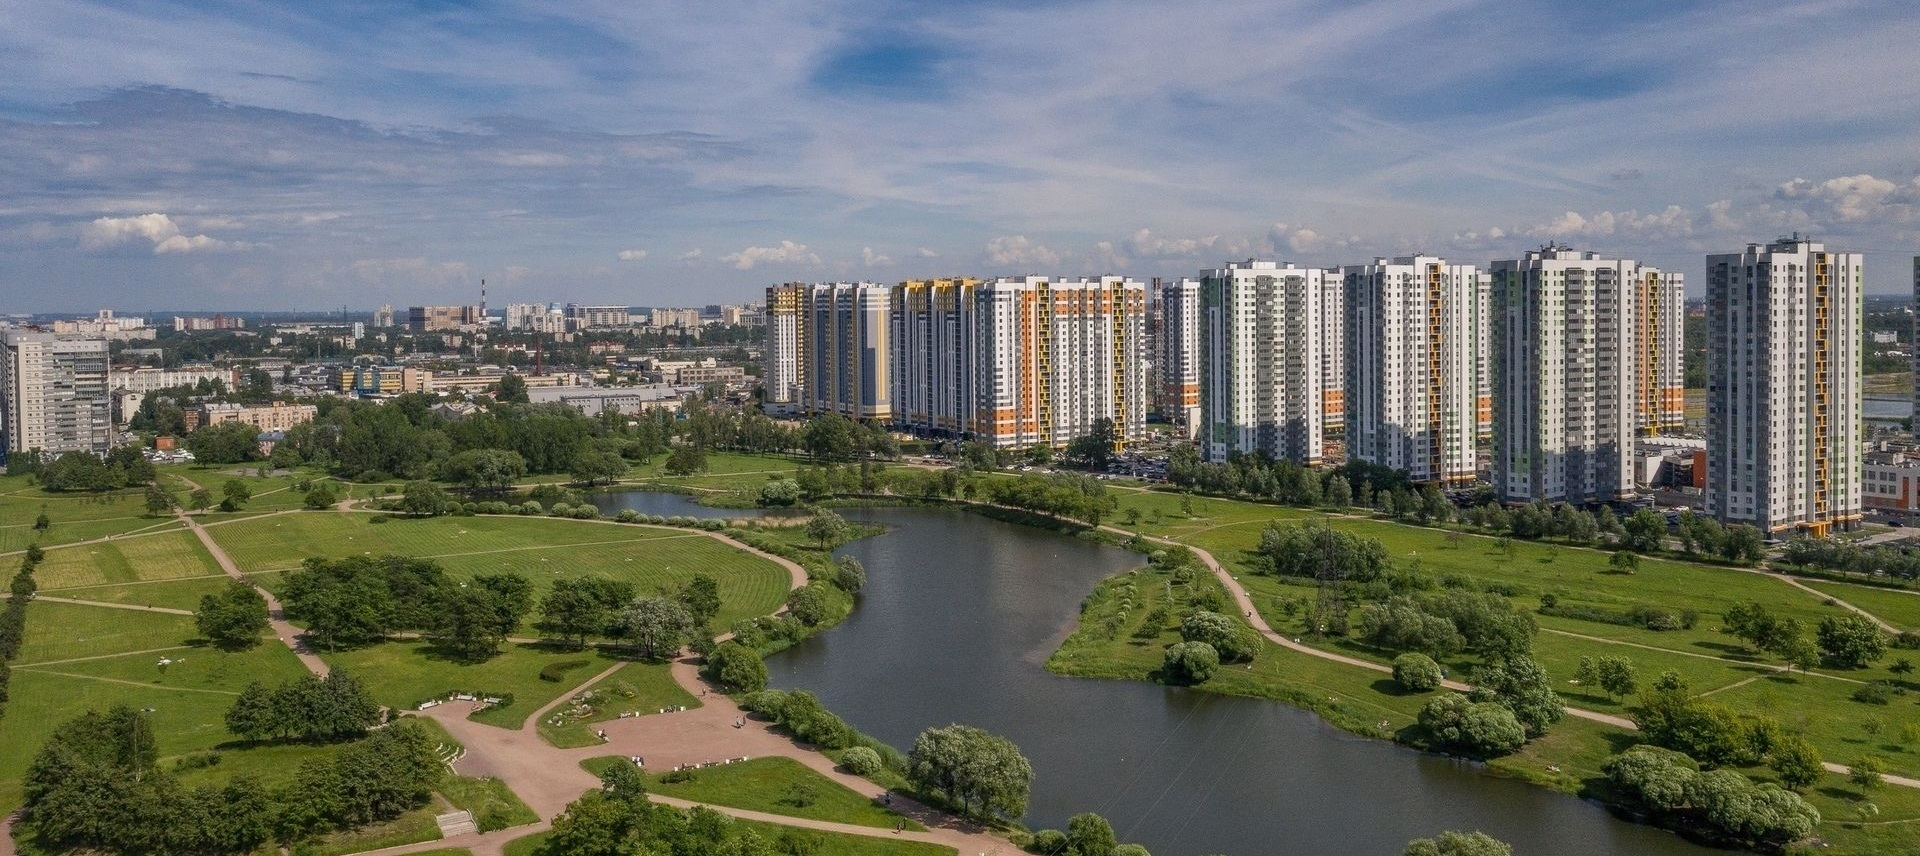

**Содержание** <a class='anchor' id='table_of_contents'></a>

* [Описание проекта](#description)
* [Описание данных](#data)
* [Шаг 1. Загрузка данных и изучение общей информации](#step_1)
* [Шаг 2. Предобработка данных](#step_2)
    * [Заполнение пропусков](#step_2_1)
    * [Изменение типов данных](#step_2_2)
    * [Обработка дубликатов](#step_2_3)
    * [Выводы по шагу 2](#step_2_4)
* [Шаг 3. Добавление дополнительных признаков](#step_3)
* [Шаг 4. Исследовательский анализ данных](#step_4)
    * [Анализ параметров объектов недвижимости](#step_4_1)
    * [Анализ времени экспозиции квартир](#step_4_2)
* [Шаг 5. Анализ факторов, влияющих на общую (полную) стоимость объекта](#step_5)
* [Выводы](#final)

## Описание проекта <a class='anchor' id='description'></a>

**Цель проекта** - определить, какие параметры влияют на рыночную стоимость недвижимости. Необходимо установить параметры, которые позволят построить автоматизированную систему для отслеживания аномалий и мошеннической деятельности. 

**Исходные данные** - данные сервиса Яндекс.Недвижимость: архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет (2014-2019 гг.).

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Описание данных <a class='anchor' id='data'></a>

Датасет `games.csv` содержит следующие признаки:

- `airports_nearest` — расстояние до ближайшего аэропорта в метрах (м)
- `balcony` — число балконов
- `ceiling_height` — высота потолков (м)
- `cityCenters_nearest` — расстояние до центра города (м)
- `days_exposition` — сколько дней было размещено объявление (от публикации до снятия)
- `first_day_exposition` — дата публикации
- `floor` — этаж
- `floors_total` — всего этажей в доме
- `is_apartment` — апартаменты (булев тип)
- `kitchen_area` — площадь кухни в квадратных метрах (м²)
- `last_price` — цена на момент снятия с публикации
- `living_area` — жилая площадь в квадратных метрах (м²)
- `locality_name` — название населённого пункта
- `open_plan` — свободная планировка (булев тип)
- `parks_around3000` — число парков в радиусе 3 км
- `parks_nearest` — расстояние до ближайшего парка (м)
- `ponds_around3000` — число водоёмов в радиусе 3 км
- `ponds_nearest` — расстояние до ближайшего водоёма (м)
- `rooms` — число комнат
- `studio` — квартира-студия (булев тип)
- `total_area` — общая площадь квартиры в квадратных метрах (м²)
- `total_images` — число фотографий квартиры в объявлении

[Назад к содержанию](#table_of_contents)

## Шаг 1. Загрузка данных и изучение общей информации <a class='anchor' id='step_1'></a>

Загрузим необходимые для проекта библиотеки и дополнительные функции.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#настройка для отображения всех столбцов датафрейма
pd.set_option('display.max_columns', None)

#настройка для отключения ошибки при перезаписи датафрейма
pd.options.mode.chained_assignment = None

In [2]:
# функция для подсчета дубликатов и получения общих сведений о датасете
def get_info(data):
    display(data.head())
    print()
    print('Число дубликатов:', data.duplicated().sum())
    print()
    data.info()

In [3]:
# функция для подсчета доли пропусков
def get_na(data):
    na_info = (
        pd.DataFrame(data.isna().mean())
        .rename(columns={0: 'NaN'})
        .style
        .set_caption('Доля пропусков')
        .background_gradient('coolwarm')
        .format('{:.2%}')
        )
    return na_info

Загрузим данные и посмотрим их содержание.

In [4]:
data = pd.read_csv('real_estate_data.csv', sep='\t')

In [5]:
get_info(data)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0



Число дубликатов: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 1

Как мы видим, в данных присутствует 23 699 записи. 14 из 22 столбцов содержат пропуски - некоторые из них постараемся заполнить медианными значениями, разбив данные на группы по количеству комнат. Некоторые столбцы формата дробных чисел следует перевести к целочисленным значениям. Столбец с датой следует привести к временному формату. Выполним эти преобразования в шаге 2.

Построим гистограмму для всех значений датафрейма.

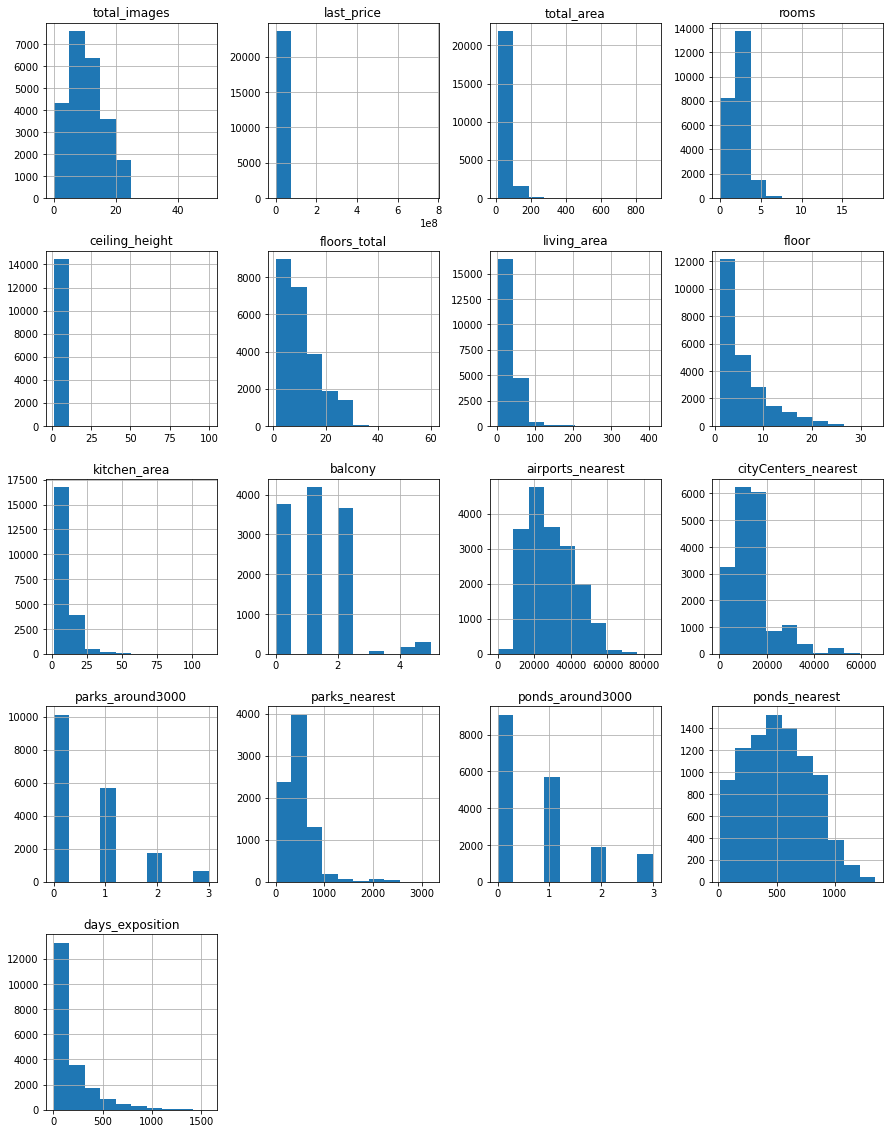

In [6]:
data.hist(figsize=(15, 20));
plt.title('Гистограмма распределений всех столбцов датафрейма');

Как видно из графиков, признаки чаще принимают пуассоновское распределение, поскольку все связаны с временными параметрами. Нормальное распределение практически не наблюдается на гистограммах. В некоторых столбцах изначально заметны аномальные значения.

[Назад к содержанию](#table_of_contents)

## Шаг 2. Предобработка данных <a class='anchor' id='step_2'></a>

### Заполнение пропусков <a class='anchor' id='step_2_1'></a>

Посмотрим сколько пропусков содержат столбцы датафрейма.

In [7]:
get_na(data)

,NaN
total_images,0.00%
last_price,0.00%
total_area,0.00%
first_day_exposition,0.00%
rooms,0.00%
ceiling_height,38.80%
floors_total,0.36%
living_area,8.03%
floor,0.00%
is_apartment,88.29%


В данных наблюдается значительное количество пропусков - их имеют 14 столбцов из 22.

Прежде чем приступить к заполнению пропусков - предобработаем столбец `rooms`, отвечающий за количество комнат в квартире. Данный столбец является одним из ключевых - далее, на основе его группировки мы сможем заполнить пропуски в других столбцах более точными значениями.

#### Предобработка столбца `rooms`

Рассмотрим уникальные значения столбца `rooms`. Для удобства отсортируем его.

In [8]:
data['rooms'].sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15, 16, 19],
      dtype=int64)

Как мы видим, в столбце имеется значение 0, что не может соответствовать действительности и является аномальным значением. Возможно, нулевое значение может быть признаком того, что квартира является студией - проверим эту гипотезу позднее.

Узнаем, сколько подобных значений встречается в столбце.

In [9]:
rooms_grouped = data.pivot_table(index='rooms', 
                                 values='total_area', 
                                 aggfunc=['count', 'median', 'min', 'max'])
rooms_grouped.columns = ['count', 'median', 'min', 'max']
rooms_grouped.head(7)

,count,median,min,max
rooms,,,,
0,197,26.05,15.5,371.0
1,8047,36.56,12.0,494.1
2,7940,53.00,20.0,196.0
3,5814,73.00,40.1,363.1
4,1180,99.30,42.0,500.0
5,326,146.45,40.0,507.0
6,105,184.30,87.0,500.0


Как мы видим, квартиры с нулевым количеством комнат имеют среднее медианное значение площади 26 кв. м, а сами значения находятся в диапазоне от 15 до 371 кв. м. Похожую конфигурацию параметров имеют однокомнатные квартиры - возможно, к их множеству можно отнести и квартиры со значением ноль в столбце `rooms`.

Чтобы убедиться в этом, подробнее взглянем на распределение квартир, имеющих ноль комнат.

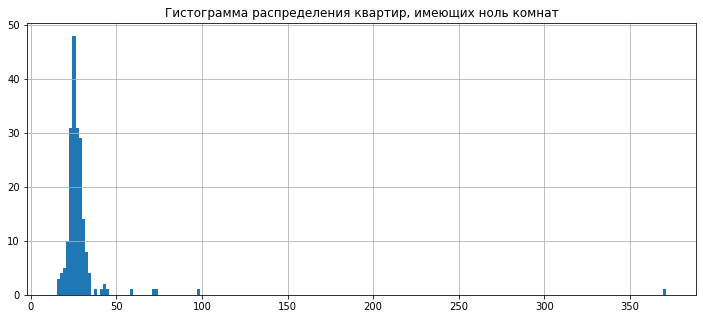

In [10]:
data[data['rooms'] == 0]['total_area'].hist(bins=200, figsize=(12, 5));
plt.title('Гистограмма распределения квартир, имеющих ноль комнат');

Как мы видим, наибольшая часть таких квартир имеет площадь не более 40-50 кв. м, на основании чего их можно отнести к категории однокомнатных квартир - сделаем это.

Вероятно, что такой тип квартир может относиться к категории студий. Проверим эту гипотезу.

In [11]:
studio_grouped = data.pivot_table(index='rooms', 
                                  values='studio', 
                                  aggfunc=['count', 'sum', 'mean'])
studio_grouped.columns = ['count', 'sum', 'mean']
studio_grouped.head(5)

,count,sum,mean
rooms,,,
0,197,138,0.700508
1,8047,11,0.001367
2,7940,0,0.000000
3,5814,0,0.000000
4,1180,0,0.000000


Как мы видим, более 70% (138 из 197) квартир с нулевым значением комнат - являются студиями. Это дает больше уверенности отнести их к категории однокомнатных квартир.

In [12]:
data.loc[data['rooms'] == 0 , 'rooms'] = 1

Удалим аномальные значения среди комнат. Рассмотрим распределение квартир, число комнат которых составляет от 7 и до 19. 

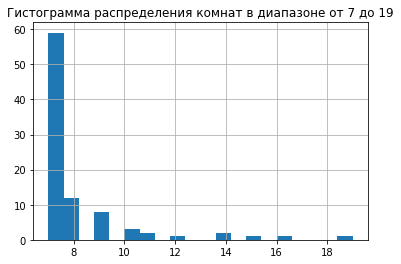

In [13]:
data['rooms'].hist(bins=20, range=(7, 19));
plt.title('Гистограмма распределения комнат в диапазоне от 7 до 19');

Как мы видим, квартиры, имеющие более 10 комнат, встречаются в данных очень редко и носят единичный характер.

Рассмотрим этот диапазон на факт наличия выбросов - построим диаграмму размаха (boxplot).

count    23699.000000
mean         2.078948
std          1.066196
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

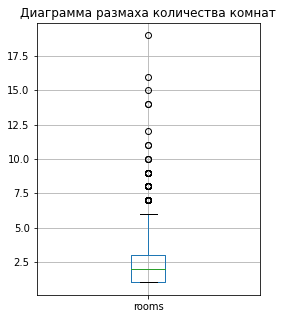

In [14]:
data.boxplot(column='rooms', figsize=(4,5));
plt.title('Диаграмма размаха количества комнат')
data['rooms'].describe()

Как мы видим, к выбросам можно отнести квартиры c 7 и более комнатами. Узнаем, сколько таких объектов содержится в датасете и какова их доля.

In [15]:
print('Квартиры с 7 и более комнатами:', len(data.query('rooms >= 7')))
print('Доля в данных:', len(data.query('rooms >= 7')) / len(data))

Квартиры с 7 и более комнатами: 90
Доля в данных: 0.00379762859192371


90 строк является малой частью датасета (0.38%), удаление таких объектов не повлияет на ход анализа и поможет очистить данные от выбросов.

Удалим строки с квартирами, имеющие 7 и более комнат. Перезапишем датафрейм, оставив строки с количеством квартир не более 6.

In [16]:
data = data.loc[(data['rooms'] <= 6)]

Убедимся в правильности полученного результата.

In [17]:
data['rooms'].value_counts()

1    8244
2    7940
3    5814
4    1180
5     326
6     105
Name: rooms, dtype: int64

#### Предобработка столбца `ceiling_height`

Как мы выяснили ранее, столбец `ceiling_height` изначально имел 9195 пропусков. В процессе преобразований их число снизилось до 9170 пропусков.

In [18]:
data['ceiling_height'].isna().sum()

9170

В рамках данной работы предлагаем заполнить пропуски медианными значениями среди квартир, сгруппированных по количеству комнат (признак `rooms`).

In [19]:
ceiling_height = data.pivot_table(index='rooms', 
                                  values='ceiling_height', 
                                  aggfunc=['median', 'mean', 'count', 'min', 'max'])
ceiling_height.columns = ['median', 'mean', 'count', 'min', 'max']
ceiling_height

,median,mean,count,min,max
rooms,,,,,
1,2.65,2.723044,4695,1.75,100.0
2,2.60,2.756499,4850,1.00,32.0
3,2.65,2.774450,3789,2.00,32.0
4,2.80,2.925737,800,2.40,27.0
5,3.10,3.171429,231,2.50,5.6
6,3.20,3.252162,74,2.50,5.2


Прежде чем заполнить пропуски, необходимо разобраться с аномальными значениями, которые наблюдаются у квартир, имеющих от 1 до 4 комнат. 

Посмотрим на распределение минимальных аномальных значений - изучим интервал от 1 м до 2 м.

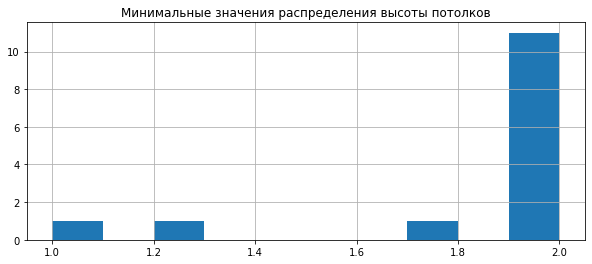

In [20]:
data['ceiling_height'].sort_values().hist(bins=10, range=(1, 2), figsize=(10,4));
plt.title('Минимальные значения распределения высоты потолков');

Как видно из графика, датасет имеет всего по одному аномально низкому значению - 1 м и 1.2 м. Удалим эти строки из датафрейма: перезапишем датафрейм `data`, оставив только те строки, где высота потолка либо больше 1.75, либо в которых имеется пропуск.

In [21]:
data = data.loc[(data['ceiling_height'] > 1.75) | (data['ceiling_height'].isna())]

Посмотрим на распределение максимальных аномальных значений в высотах потолка - изучим значения от 5 м до 100 м.

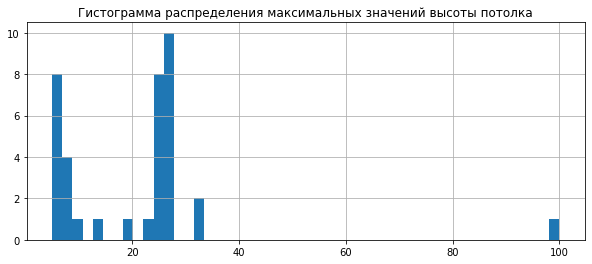

In [22]:
data['ceiling_height'].sort_values().hist(bins=50, range=(5, 100), figsize=(10,4));
plt.title('Гистограмма распределения максимальных значений высоты потолка');

In [23]:
ceiling_grouped_raw = data.groupby('ceiling_height') \
                            .agg({'ceiling_height':['count']})
ceiling_grouped_raw.columns = ['count']
ceiling_grouped_raw.sort_values(by='ceiling_height', ascending=False).head(10)

,count
ceiling_height,
100.0,1
32.0,2
27.5,1
27.0,8
26.0,1
25.0,7
24.0,1
22.6,1
20.0,1


Прежде чем удалять максимальные аномальные значения, попробуем исправить ошибки в данных.

Применим лямбда-функцию, которая заменит аномальные значения высоты потолка. Функция будет понижать порядок (умножать на 0.1) у значений больше 20 м. Применим функцию к столбцу `ceiling_height`.

In [24]:
data['ceiling_height'] = data['ceiling_height'].apply(lambda x: x * 0.1 if x >= 20 else x)

Убедимся, что столбец `ceiling_height` был скорректирован верно и не имеет значений высоты потолка более 20 м.

In [25]:
ceiling_grouped_fixed = data.groupby('ceiling_height') \
                            .agg({'ceiling_height':['count']})
ceiling_grouped_fixed.columns = ['count']
ceiling_grouped_fixed.sort_values(by='ceiling_height', ascending=False).head(5)

,count
ceiling_height,
14.0,1
10.3,1
10.0,1
8.3,1
8.0,3


count    14436.000000
mean         2.727100
std          0.316146
min          2.000000
25%          2.510000
50%          2.650000
75%          2.800000
max         14.000000
Name: ceiling_height, dtype: float64

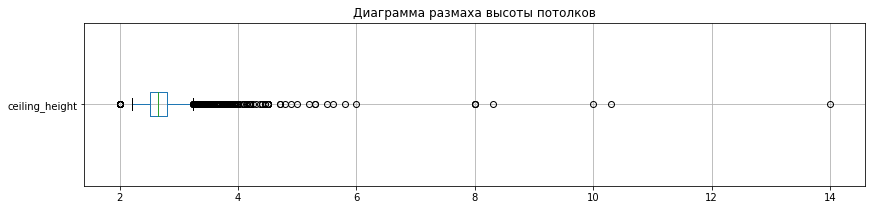

In [26]:
data.boxplot(column='ceiling_height', figsize=(14,3), vert=False);
plt.title('Диаграмма размаха высоты потолков');
data['ceiling_height'].describe()

Теперь, удалим все строки, в которых `ceiling_height` превышает 5 м. Перезапишем датафрейм `data`, оставив только те строки, где высота потолка меньше или равна 5, или содержит пропуск.

In [27]:
data = data.loc[(data['ceiling_height'] <= 5) | (data['ceiling_height'].isna())]

#### Заполнение пропусков в `ceiling_height`

После того, как столбец `ceiling_height` был предобработан и очищен от аномальных значений, мы можем заполнить пропуски в нем.

In [28]:
print('Всего пропусков:', data['ceiling_height'].isna().sum())
data[data['ceiling_height'].isna()]['rooms'].value_counts()

Всего пропусков: 9170


1    3549
2    3090
3    2025
4     380
5      95
6      31
Name: rooms, dtype: int64

Посмотрим, каково распределение величин в данном столбце.

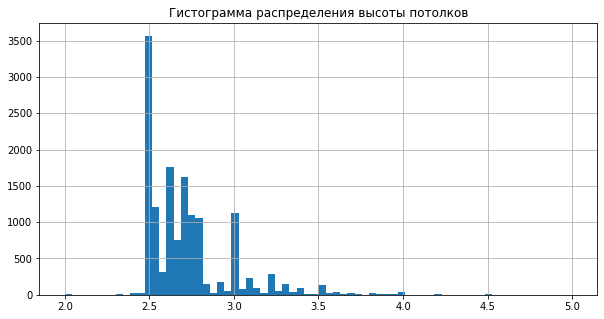

In [29]:
data['ceiling_height'].hist(bins=70, figsize=(10, 5));
plt.title('Гистограмма распределения высоты потолков');

Мы видим, что большинство значений находит в интервале от 2.5 м до 3.0 м. В интервале от 3.0 м до 3.5 м наблюдается существенное снижение количество таких случаев. Высота потолка более 3.5 встречается уже весьма редко.

Посмотрим на медианные значения высоты потолков среди разных квартир. Сгруппируем данные и рассчитаем для них медиану и количество.

In [30]:
data.pivot_table(index='rooms', values='ceiling_height', aggfunc=['median', 'count'])

,median,count
,ceiling_height,ceiling_height
rooms,,
1,2.65,4688
2,2.60,4846
3,2.65,3787
4,2.80,799
5,3.10,229
6,3.20,73


Заполним пропуски в `ceiling_height` медианными значениями, сгруппировав данные по количеству комнат (`rooms`).

In [31]:
data_transformed = data.groupby('rooms')['ceiling_height'].transform('median')
data['ceiling_height'] = data['ceiling_height'].fillna(data_transformed)

Убедимся, что пропусков в столбце `ceiling_height` не осталось.

In [32]:
data['ceiling_height'].isna().sum()

0

#### Заполнение пропусков в `balcony`

Заполним пропуски в столбце `balcony`. Посмотрим, каково их количество и доля.

In [33]:
print('Всего пропусков:', data['balcony'].isna().sum())
print('Доля пропусков:', data['balcony'].isna().mean())

Всего пропусков: 11459
Доля пропусков: 0.485715496778569


Почти половина столбца (48.6%) имеет пропуски, что достаточно критично. Посмотрим, как распределяются имеющиеся значения.

In [34]:
data['balcony'].value_counts()

1.0    4178
0.0    3735
2.0    3656
5.0     301
4.0     183
3.0      80
Name: balcony, dtype: int64

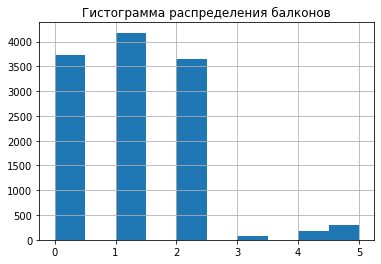

In [35]:
data['balcony'].hist();
plt.title('Гистограмма распределения балконов');

Чаще всего квартиры имеют 1-2 балкона, также часто не имеют его вовсе. Наличие трех и более балконов большая редкость, однако, наличие пяти балконов можно встретить гораздо чаще, чем 3 или 4.

Будем считать, что если сведения о балконе не указаны - значит он отсутствует в квартире. На основании этого заполним пропуски в столбце нулевыми значениями.

In [36]:
data['balcony'] = data['balcony'].fillna(0)

#### Заполнение пропусков в `living_area`

Заполним пропуски в столбце `living_area`. Посмотрим, каково их количество и доля.

In [37]:
print('Всего пропусков:',data['living_area'].isna().sum())
print('Доля пропусков:', data['living_area'].isna().mean())

Всего пропусков: 1894
Доля пропусков: 0.0802814513394371


Количество пропусков составляет 8%. Заполним пропуски медианными значениями, сгруппировав квартиры по количеству комнат. Посмотрим, каковы медианные значения в сводной таблице.

In [38]:
data.pivot_table(index='rooms', values='living_area', aggfunc='median')

,living_area
rooms,
1,17.60
2,30.50
3,45.00
4,63.55
5,91.77
6,123.75


На основе этого принципа, заполним пропуски с помощью лямбда-функции, которая передаст внутригрупповое медианное значение жилой площади.

In [39]:
data['living_area'] = data.groupby('rooms')['living_area'].apply(lambda s: s.fillna(s.median()))

#### Заполнение пропусков в `kitchen_area`

Заполним пропуски в столбце `kitchen_area`. Посмотрим, каково их количество и доля.

In [40]:
print('Всего пропусков:', data['kitchen_area'].isna().sum())
print('Доля пропусков:', data['kitchen_area'].isna().mean())

Всего пропусков: 2262
Доля пропусков: 0.09587995930824009


Количество пропусков составляет около 10%. Заполним пропуски медианными значениями, сгруппировав квартиры по количеству комнат. Посмотрим, каковы медианные значения в сводной таблице.

In [41]:
data.pivot_table(index='rooms', values='kitchen_area', aggfunc='median')

,kitchen_area
rooms,
1,9.05
2,8.80
3,9.50
4,11.05
5,15.05
6,19.30


Аналогично, заполним пропуски с помощью лямбда-функции, которая передаст внутригрупповое медианное значение площади кухни.

In [42]:
data['kitchen_area'] = data.groupby('rooms')['kitchen_area'].apply(lambda s: s.fillna(s.median()))

#### Заполнение пропусков в `floors_total`

Столбец `floors_total` имеет сравнительно малое количество пропусков - 86. Однако, этот столбец достаточно важен для дальнейшего анализа, в связи с чем удалим строки, не имеющих данных о количестве этажей в доме.

In [43]:
data['floors_total'].isna().sum()

86

In [44]:
data.dropna(subset = ['floors_total'], inplace=True)

#### Предобработка `locality_name`

Столбец `locality_name` изначально имел 49 пропусков, в процессе предобработки их число снизилось до 48.

In [45]:
print('Всего пропусков:', data['locality_name'].isna().sum())
print('Доля пропусков:', data['locality_name'].isna().mean())

Всего пропусков: 48
Доля пропусков: 0.002042031821662554


Данный столбец является важным в последующем ходе исследования, поэтому удалим строки с отсутствующими значениями.

In [46]:
data.dropna(subset = ['locality_name'], inplace=True)

#### Заполнение пропусков в картографических данных

Будем считать, что если сведения о наличии парков и водоемов не указаны - то в радиусе 3 км их нет. Заполним соответствующие пропуски нулевыми значениями.

In [47]:
data['ponds_around3000'] = data['ponds_around3000'].fillna(value=0)
data['parks_around3000'] = data['parks_around3000'].fillna(value=0)

### Изменение типов данных <a class='anchor' id='step_2_2'></a>

Рассмотрим какие типы данных присутствуют в датафрейме.

In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23458 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23458 non-null  int64  
 1   last_price            23458 non-null  float64
 2   total_area            23458 non-null  float64
 3   first_day_exposition  23458 non-null  object 
 4   rooms                 23458 non-null  int64  
 5   ceiling_height        23458 non-null  float64
 6   floors_total          23458 non-null  float64
 7   living_area           23458 non-null  float64
 8   floor                 23458 non-null  int64  
 9   is_apartment          2753 non-null   object 
 10  studio                23458 non-null  bool   
 11  open_plan             23458 non-null  bool   
 12  kitchen_area          23458 non-null  float64
 13  balcony               23458 non-null  float64
 14  locality_name         23458 non-null  object 
 15  airports_nearest   

В данных присутствуют 2 столбца с булевыми значениями, 14 столбцов с дробными числами, 3 столбца с целыми чисами и 3 строковых столбца.

Столбец `first_day_exposition` представлен типом данных object, что является строкой. Приведем его к типу datetime.

In [49]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%d')

Следующие столбцы представлены типом данных float64 - числа с плавающей точкой: 
- `floors_total` - всего этажей в доме;
- `balcony` - число балконов;
- `parks_around3000` - число парков в радиусе 3 км;
- `ponds_around3000` - число водоёмов в радиусе 3 км.

Оставлять эти данные в дробных значениях не имеет смысла для анализа, поэтому приведем его к типу int32 - целые числа.

In [50]:
data['floors_total'] = data['floors_total'].astype('int32')
data['balcony'] = data['balcony'].astype('int32')
data['parks_around3000'] = data['parks_around3000'].astype('int32')
data['ponds_around3000'] = data['ponds_around3000'].astype('int32')

### Обработка дубликатов <a class='anchor' id='step_2_3'></a>

Неявные дубликаты могут находиться в строковых столбцах. В нашем датасете таким столбцом является `locality_name`. Рассмотрим его подробнее.

In [51]:
data['locality_name'].nunique()

364

Данные имеют 364 разнообразных названия населенных пунктов. 

Посмотрим, как наличие буквы `ё` распределяется среди названий на примере слова `поселок`.

In [52]:
print('Количество строк с "посёлок":', len(data[data['locality_name'].str.startswith("посёлок")]))
print('Количество строк с "поселок":', len(data[data['locality_name'].str.startswith("поселок")]))

Количество строк с "посёлок": 1936
Количество строк с "поселок": 524


Заменим букву `ё` на букву `е` во всех значениях столбца.

In [53]:
data['locality_name'] = data['locality_name'].str.replace('ё', 'е')

Посмотрим, как это повлияло на количество уникальных значений.

In [54]:
data['locality_name'].nunique()

330

Посмотрим визуально на уникальные значение столбца и постараемся выделить наиболее часто встречаемые.

In [55]:
data['locality_name'].sort_values().unique()

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалево',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской поселок Большая Ижора', 'городской поселок Будогощь',
       'городской поселок Виллози', 'городской поселок Лесогорский',
       'городской поселок Мга', 'городской поселок Назия',
       'городской поселок Новоселье', 'городской поселок Павлово',
       'городской поселок Рощино', 'городской поселок Свирьстрой',
       'городской поселок Советский', 'городской поселок Фед

Как видно из массива, наиболее чаще встречаются города, деревни, поселки, садовые товарищества и села.

Приведем все названия к единому типу.

In [56]:
data['locality_name'] = data['locality_name'].str.replace('поселок городского типа', 'поселок')
data['locality_name'] = data['locality_name'].str.replace('городской поселок', 'поселок')
data['locality_name'] = data['locality_name'].str.replace('коттеджный поселок', 'поселок')
data['locality_name'] = data['locality_name'].str.replace('поселок при железнодорожной станции', 'поселок')
data['locality_name'] = data['locality_name'].str.replace('садоводческое некоммерческое товарищество', 'поселок')

In [57]:
data['locality_name'].nunique()

321

Таким образом, мы снизили количество неявных дубликатов с 364 до 321.

### Выводы по шагу 2 <a class='anchor' id='step_2_4'></a>

На данном этапе были решены следующие задачи:
1. Предобработан столбец `rooms`: квартиры с нулевым значением комнат отнесены в категорию однокомнатных; удалены строки с 7 и более комнатами (90 строк удалено). Столбец обрабатывался в первую очередь для заполнения пропусков других столбцов.
2. Предобработан столбец `ceiling_height`: исправлены ошибки в данных (значения более 20 м); удалены строки с высотой потолка более 5 м. Пропуски были заполнены медианными значениями в группировке по количеству комнат.
3. Пропуски столбца `balcony` заполнены нулевыми значениями.
4. Пропуски столбца `living_area` были заполнены внутригрупповыми медианными значениями жилой площади в разбивке по количеству комнат.
5. Пропуски столбца `kitchen_area` были заполнены внутригрупповыми медианными значениями жилой площади в разбивке по количеству комнат.
6. Строки с пропусками столбца `floors_total` были удалены (удалено 86 строк).
7. Строки с пропусками столбца `locality_name` были удалены (удалено 48 строк).
8. Пропуски столбцов `ponds_around3000` и `ponds_around3000`были заполнены нулевыми значениями.
9. Столбец `first_day_exposition` приведен к типу `datetime64`.
10. Столбцы `floors_total`, `balcony`, `parks_around3000` и `ponds_around3000` были приведены к типу `int32`.
11. В столбце `locality_name` обработаны неявные дубликаты - их количество снижено с 364 до 321.

[Назад к содержанию](#table_of_contents)

## Шаг 3. Добавление дополнительных признаков <a class='anchor' id='step_3'></a>

Добавим в таблицу новые столбцы со следующими параметрами:
- `price_per_square_meter` - цена одного квадратного метра;
- `exposition_weekday` - день недели публикации объявления (0 — понедельник, 1 — вторник и т.д.);
- `exposition_month` - месяц публикации объявления;
- `exposition_year` - год публикации объявления;
- `floor_type` - тип этажа квартиры (значения — «первый», «последний», «другой»);
- `cityCenters_nearest_km` - расстояние до центра города в километрах.

### Расчет цены квадратного метра жилья

Добавим в таблицу новый столбец с ценой квадратного метра жилья.

In [58]:
data['price_per_square_meter'] = data['last_price'] / data['total_area']

### Добавление времени публикации

Добавим столбцы с годом, месяцем и днем недели публикации объявления.

In [59]:
data['exposition_year'] = data['first_day_exposition'].dt.year
data['exposition_month'] = data['first_day_exposition'].dt.month
data['exposition_weekday'] = data['first_day_exposition'].dt.weekday

In [60]:
data.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_square_meter,exposition_year,exposition_month,exposition_weekday
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,NaN,False,False,25.0,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,NaN,120370.370370,2019,3,3
1,7,3350000.0,40.4,2018-12-04,1,2.65,11,18.6,1,NaN,False,False,11.0,2,поселок Шушары,12817.0,18603.0,0,NaN,0,NaN,81.0,82920.792079,2018,12,1
2,10,5196000.0,56.0,2015-08-20,2,2.60,5,34.3,4,NaN,False,False,8.3,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558.0,92785.714286,2015,8,3
3,0,64900000.0,159.0,2015-07-24,3,2.65,14,45.0,9,NaN,False,False,9.5,0,Санкт-Петербург,28098.0,6800.0,2,84.0,3,234.0,424.0,408176.100629,2015,7,4
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,NaN,False,False,41.0,0,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121.0,100000.000000,2018,6,1


### Тип этажей квартиры

Создадим столбец `floor_type` и заполним его по умолчанию значением `другой`.

In [61]:
data['floor_type'] = 'другой'

Далее, найдем строки, где этаж является первым и пометим их как `первый`.

In [62]:
data['floor_type'] = data['floor_type'].where(data['floor'] != 1, 'первый')

Аналогично, найдем строки, где этаж является последним и пометим их как `последний`.

In [63]:
data['floor_type'] = data['floor_type'].where(data['floor'] != data['floors_total'] , 'последний')

Проверим правильность заполнения столбца.

In [64]:
data.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_square_meter,exposition_year,exposition_month,exposition_weekday,floor_type
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,NaN,False,False,25.0,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,NaN,120370.370370,2019,3,3,другой
1,7,3350000.0,40.4,2018-12-04,1,2.65,11,18.6,1,NaN,False,False,11.0,2,поселок Шушары,12817.0,18603.0,0,NaN,0,NaN,81.0,82920.792079,2018,12,1,первый
2,10,5196000.0,56.0,2015-08-20,2,2.60,5,34.3,4,NaN,False,False,8.3,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558.0,92785.714286,2015,8,3,другой
3,0,64900000.0,159.0,2015-07-24,3,2.65,14,45.0,9,NaN,False,False,9.5,0,Санкт-Петербург,28098.0,6800.0,2,84.0,3,234.0,424.0,408176.100629,2015,7,4,другой
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,NaN,False,False,41.0,0,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121.0,100000.000000,2018,6,1,другой


### Расстояние до центра города в километрах 

Добавим в датафрейм расстояние до центра города в километрах.

In [65]:
data['cityCenters_nearest_km'] = (data['cityCenters_nearest'] / 1000).round()

In [66]:
data.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_square_meter,exposition_year,exposition_month,exposition_weekday,floor_type,cityCenters_nearest_km
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,NaN,False,False,25.0,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,NaN,120370.370370,2019,3,3,другой,16.0
1,7,3350000.0,40.4,2018-12-04,1,2.65,11,18.6,1,NaN,False,False,11.0,2,поселок Шушары,12817.0,18603.0,0,NaN,0,NaN,81.0,82920.792079,2018,12,1,первый,19.0
2,10,5196000.0,56.0,2015-08-20,2,2.60,5,34.3,4,NaN,False,False,8.3,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558.0,92785.714286,2015,8,3,другой,14.0
3,0,64900000.0,159.0,2015-07-24,3,2.65,14,45.0,9,NaN,False,False,9.5,0,Санкт-Петербург,28098.0,6800.0,2,84.0,3,234.0,424.0,408176.100629,2015,7,4,другой,7.0
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,NaN,False,False,41.0,0,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121.0,100000.000000,2018,6,1,другой,8.0


### Выводы по шагу 3

На данном этапе были добавлены следующие столбцы:
- `price_per_square_meter` - цена одного квадратного метра;
- `exposition_weekday` - день недели публикации объявления (0 — понедельник, 1 — вторник и т.д.);
- `exposition_month` - месяц публикации объявления;
- `exposition_year` - год публикации объявления;
- `floor_type` - тип этажа квартиры (значения — «первый», «последний», «другой»);
- `cityCenters_nearest_km` - расстояние до центра города в километрах.

[Назад к содержанию](#table_of_contents)

## Шаг 4. Исследовательский анализ данных <a class='anchor' id='step_4'></a>

### Анализ параметров объектов недвижимости <a class='anchor' id='step_4_1'></a>

Проведем исследовательский анализ следующих параметров объектов:
- общая площадь;
- жилая площадь;
- площадь кухни;
- цена объекта;
- количество комнат;
- высота потолков;
- этаж квартиры;
- тип этажа квартиры («первый», «последний», «другой»);
- общее количество этажей в доме;
- расстояние до центра города в метрах;
- расстояние до ближайшего аэропорта;
- расстояние до ближайшего парка;
- день и месяц публикации объявления.

#### Общая площадь (`total_area`)

Рассмотрим общую площадь объектов - построим для них гистограмму и вычислим описательные статистические показатели.

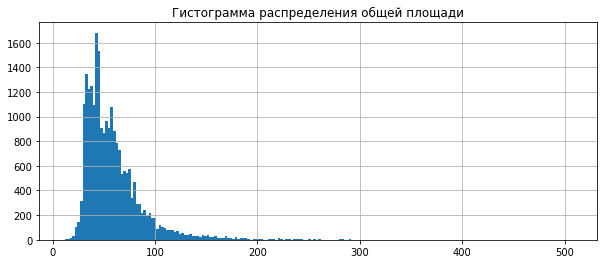

In [67]:
data['total_area'].hist(bins=200, figsize=(10,4));
plt.title('Гистограмма распределения общей площади');

Как видно из графика распределения, который по своей сути напоминает нормальное распределение, но с весьма длинным "хвостом" нетипичных значений - большинство объектов недвижимости имеет общую площадь в диапазоне 50-100 кв. м.

In [68]:
data['total_area'].describe()

count    23458.000000
mean        59.446413
std         31.838743
min         12.000000
25%         40.000000
50%         52.000000
75%         69.100000
max        507.000000
Name: total_area, dtype: float64

Вывод выше также подтверждается и значением медианы - 52 кв. м. Среднее значение площади не сильно отличается от медианы и составляет 59.4 кв. м. Среднее отклонение весьма высокое - 31.8. Это связано с наличием нетипично высоких значений, которые можно отнести к выбросам. Максимальное значени составляет 507 кв. м. Подозрительно выглядит минимальное значение, составляющее 12 кв. м. Посмотрим подробнее, что это за объекты.

In [69]:
data.query('total_area < 15')[['total_area', 'rooms', 'floors_total', 'locality_name']]

,total_area,rooms,floors_total,locality_name
17961,13.0,1,9,Санкт-Петербург
19546,13.0,1,5,Санкт-Петербург
19558,13.2,1,5,Санкт-Петербург
19642,14.0,1,5,Санкт-Петербург
19807,13.0,1,5,Санкт-Петербург
19904,12.0,1,5,Санкт-Петербург


Видимо, значения этих объектов не являются аномальными и имеют место быть. Большинство из них представляют собой очень маленькие квартиры в пятиэтажках Санкт-Петербурга.

Рассмотрим выбросы подробнее, построим диаграмму размаха типа boxplot.

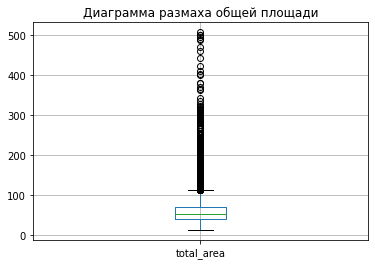

In [70]:
data.boxplot(column='total_area');
plt.title('Диаграмма размаха общей площади');

Как видно из диаграммы, значения более 120-130 кв. м уже выходят за пределы 3-го квартиля, и далее, составляют длинный шлейф высоких значений.

Посмотрим, сколько значений выбиваются за пределы межквартильного размаха.

In [71]:
len(data.query('total_area > 130'))

742

Количество объектов с общей площадью более 130 кв. м - 742, что составляет около 3% от всех данных. Мы не будем удалять аномальные значения в этом столбце, поскольку их наличие не должно сказаться на выводах исследования.

#### Жилая площадь (`living_area`)

Рассмотрим жилую площадь объектов - построим для них гистограмму и вычислим описательные статистические показатели.

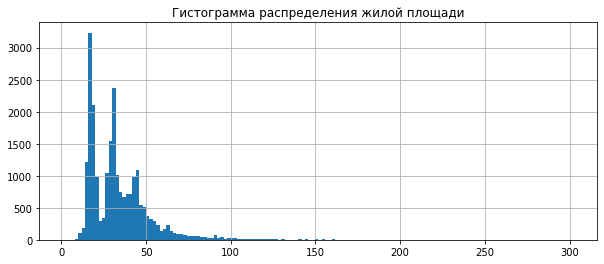

In [72]:
data['living_area'].hist(bins=150, figsize=(10,4));
plt.title('Гистограмма распределения жилой площади');

Как видно из графика, распределение жилой площади в целом напоминает распределение общей площади, но имеет большую амплитуду количество значений в выборке. Наибольшая часть объектов имеет жилую площадь не выше 50 кв. м. После 100 кв. м мы также наблюдаем длинный "хвост" нетипичных значений, который простирается аналогичным способом как и у общей площади - эти две величины имеют высокую корреляцию. Это ясно из здравого смысла, и мы также убедимся в этом в пункте 4.3.1.

In [73]:
data['living_area'].describe()

count    23458.000000
mean        33.777631
std         19.514065
min          2.000000
25%         18.400000
50%         30.200000
75%         42.400000
max        301.500000
Name: living_area, dtype: float64

Значение медианы - 30.2 кв. м. Среднее значение площади не сильно отличается от медианы и составляет 33.7 кв. м. Среднее отклонение весьма высокое - 19.5. Как и в случае с общей площадью, это связано с наличием нетипично высоких значений, которые можно отнести к выбросам. Максимальное значени составляет 301.5 кв. м. Подозрительно выглядит минимальное значение, составляющее 2 кв. м. Посмотрим подробнее, что это за объекты.

In [74]:
data.query('living_area < 5')[['total_area', 'rooms', 'living_area']]

,total_area,rooms,living_area
3242,41.0,1,3.0
13915,52.0,2,2.0
21758,23.0,1,2.0
23574,139.0,3,3.0


Здесь мы видим объекты с нереалистично низкой жилой площадью - например, общая площадь - 139 кв. м, а жилая - лишь 3 кв. м, при том, что квартира является 3-комнатной и не является студией. Удалим объекты, жилая площадь которых меньше 5 кв. м.

In [75]:
data = data.loc[(data['living_area'] >= 5)]

Рассмотрим выбросы подробнее, построим диаграмму размаха типа boxplot.

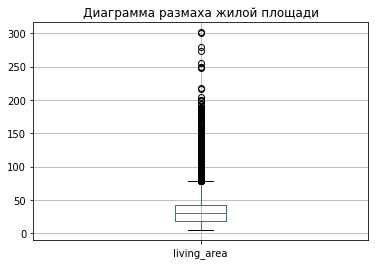

In [76]:
data.boxplot(column='living_area');
plt.title('Диаграмма размаха жилой площади');

Как видно из диаграммы, значения более 80 кв. м уже выходят за пределы 3-го квартиля, и далее, составляют длинный шлейф высоких значений.

Посмотрим, сколько значений выбиваются за пределы межквартильного размаха.

In [77]:
len(data.query('living_area > 80'))

637

Количество объектов с жилой площадью более 80 кв. м - 637, что составляет 2.7% от всех данных. Мы не будем удалять аномальные значения в этом столбце, поскольку их наличие не должно сказаться на выводах исследования.

#### Площадь кухни (`kitchen_area`)

Рассмотрим площадь кухни объектов - построим для них гистограмму и вычислим описательные статистические показатели.

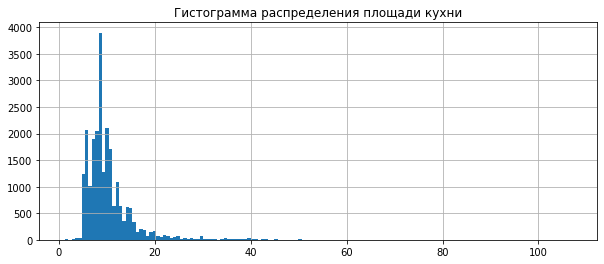

In [78]:
data['kitchen_area'].hist(bins=150, figsize=(10,4));
plt.title('Гистограмма распределения площади кухни');

Как видно из графика распределения, который по своей сути напоминает нормальное распределение, но с весьма длинным "хвостом" нетипичных значений - большинство объектов недвижимости имеет площадь кухни в диапазоне 5-20 кв. метров.

In [79]:
data['kitchen_area'].describe()

count    23454.000000
mean        10.392049
std          5.484043
min          1.300000
25%          7.300000
50%          9.050000
75%         11.400000
max        107.000000
Name: kitchen_area, dtype: float64

Значение медианы - 9 кв. м. Среднее значение площади не сильно отличается от медианы и составляет 10.4 кв. м. Среднее отклонение весьма высокое - 5.5. Как и в случае с общей и жилой площадью, это связано с наличием нетипично высоких значений, которые можно отнести к выбросам. Максимальное значение составляет 107 кв. м. Подозрительно выглядит минимальное значение, составляющее 1.3 кв. м. Посмотрим подробнее, что это за объекты.

In [80]:
data.query('kitchen_area <= 2')[['total_area', 'rooms', 'kitchen_area']]

,total_area,rooms,kitchen_area
906,27.00,1,2.0
6262,24.00,2,2.0
9138,23.29,1,2.0
11033,32.00,1,2.0
16367,25.70,1,2.0
19642,14.00,1,2.0
20217,28.50,1,1.3
21419,20.00,1,2.0


Как видно из среза данных, подобные объекты и правда являются очень маленькими квартирами, в которых площадь кухни принимает самые минимальные значения.

Рассмотрим выбросы подробнее, построим диаграмму размаха типа boxplot.

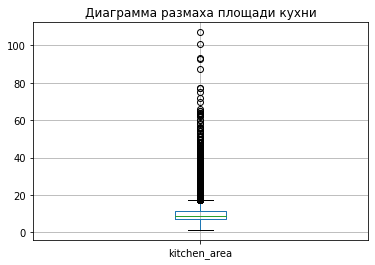

In [81]:
data.boxplot(column='kitchen_area');
plt.title('Диаграмма размаха площади кухни');

Как видно из диаграммы, значения более 20 кв. м уже выходят за пределы 3-го квартиля, и далее, составляют длинный шлейф высоких значений.

Посмотрим, сколько значений выбиваются за пределы межквартильного размаха.

In [82]:
len(data.query('kitchen_area > 20'))

974

Количество объектов с площадью кухни более 20 кв. м - 974, что составляет около 4% от всех данных. Мы не будем удалять аномальные значения в этом столбце, поскольку их наличие не должно сказаться на выводах исследования.

#### Цена объекта (`last_price`)

Для удобства анализа создадим дополнительный столбец `last_price_mln`, в котором выразим стоимость в млн руб.

In [83]:
data['last_price_mln'] = data['last_price'] / 1_000_000

Рассмотрим цены объектов - построим для них гистограмму и вычислим описательные статистические показатели.

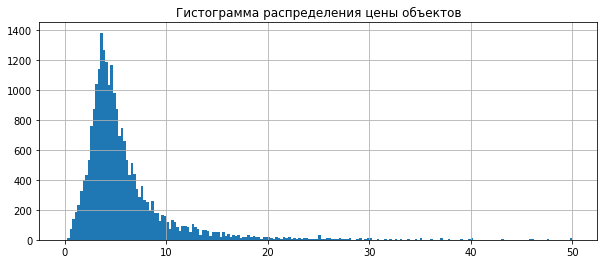

In [84]:
data['last_price_mln'].hist(bins=200, figsize=(10,4), range=(0, 50));
plt.title('Гистограмма распределения цены объектов');

Как видно из графика, наибольшая часть цен не превышает 10-15 млн руб. Распределение напоминает нормальное, но имеет большое количество выбросов.

In [85]:
data['last_price_mln'].describe()

count    23454.000000
mean         6.348228
std          8.661543
min          0.012190
25%          3.400000
50%          4.600000
75%          6.700000
max        401.300000
Name: last_price_mln, dtype: float64

Значение медианы - 4.6 млн руб. Среднее значение стоимости не сильно отличается от медианы и составляет 6.35 млн руб. Среднее отклонение весьма высокое - 8.66. Как и в случае с площадью, это связано с наличием нетипично высоких значений, которые можно отнести к выбросам. Максимальное значение составляет 401 млн руб. Минимальное значение составляет 12 190 руб. Посмотрим подробнее, что это за объекты.

In [86]:
data.query('last_price < 400000')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_square_meter,exposition_year,exposition_month,exposition_weekday,floor_type,cityCenters_nearest_km,last_price_mln
8793,7,12190.0,109.0,2019-03-20,2,2.75,25,32.0,25,NaN,False,False,40.5,0,Санкт-Петербург,36421.0,9176.0,1,805.0,0,NaN,8.0,111.834862,2019,3,2,последний,9.0,0.01219


Вероятно, эта строка имеет ошибку в значении цены. Данная двухкомнатная квартира имеет высокую площадь (109 кв. м), в связи с чем, скорее всего, ее стоимость должна быть 12 190 000, а не 12 190. Исправим эту ошибку.

In [87]:
data.loc[data['last_price'] == 12190, 'last_price'] = 12190 * 1000
data.loc[data['last_price_mln'] == 0.01219, 'last_price_mln'] = 0.01219 * 1000

Взглянем на сверхвысокие значения стоимости - более 200 млн руб.

In [88]:
data.query('last_price_mln > 200')[['last_price', 'total_area', 'rooms', 'locality_name', 'cityCenters_nearest_km']]

,last_price,total_area,rooms,locality_name,cityCenters_nearest_km
1436,330000000.0,190.0,3,Санкт-Петербург,1.0
5893,230000000.0,500.0,6,Санкт-Петербург,5.0
13749,240000000.0,410.0,6,Санкт-Петербург,5.0
14706,401300000.0,401.0,5,Санкт-Петербург,2.0
16461,245000000.0,285.7,6,Санкт-Петербург,6.0
22831,289238400.0,187.5,2,Санкт-Петербург,1.0


Как мы видим, таких объектов немного - все они являются квартирами в центре города, в связи с чем наблюдается такая экстримально высокая стоимость.

Рассмотрим выбросы подробнее, построим диаграмму размаха типа boxplot.

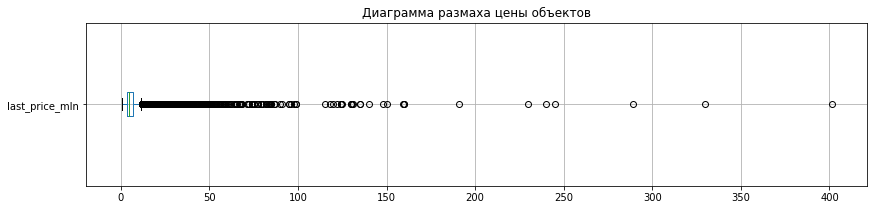

In [89]:
data.boxplot(column='last_price_mln', figsize=(14,3), vert=False);
plt.title('Диаграмма размаха цены объектов');

Как видно из диаграммы, значения более 10-15 млн руб. уже выходят за пределы 3-го квартиля, и далее, составляют длинный шлейф высоких значений.

Посмотрим, сколько значений выбиваются за пределы межквартильного размаха.

In [90]:
len(data.query('last_price_mln > 15'))

1109

Количество объектов стоимостью более 15 млн руб. - 1109, что составляет 4.7% от всех данных. Мы не будем удалять аномальные значения в этом столбце, поскольку их наличие не должно сказаться на выводах исследования.

#### Количество комнат (`rooms`)

Данный столбец был подробно рассмотрен и предобработан в пункте 2.1.1. в целях заполнения пропусков других столбцов медианными значениями.

Рассмотрим количество комнат объектов - построим для них гистограмму.

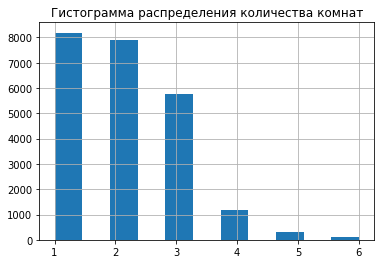

In [91]:
data['rooms'].hist(bins=11);
plt.title('Гистограмма распределения количества комнат');

Чаще всего на рынке недвижимости встречаются однокомнатные, двухкомнатные и трехкомнатные квартиры.

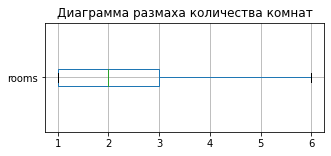

In [92]:
data.boxplot(column='rooms', figsize=(5,2), vert=False);
plt.title('Диаграмма размаха количества комнат');

В пункте 2.1.1. были удалены объекты, количество квартир которых превышало 6 комнат. Максимальными были значения 19 комнат.

#### Высота потолков (`ceiling_height`)

Данный столбец был подробно рассмотрен и предобработан в пункте 2.1.2. Пропуски столбца были заполнены медианными значениями в пункте 2.1.3.

Рассмотрим высоту потолков объектов - построим для них гистограмму и вычислим описательные статистические показатели.

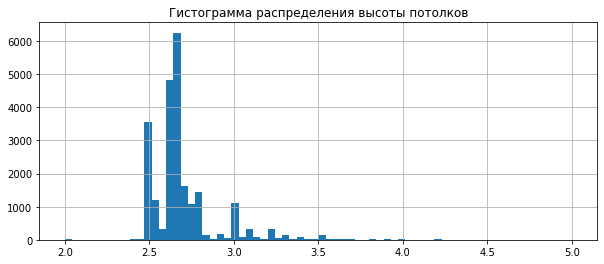

In [93]:
data['ceiling_height'].hist(bins=70, figsize=(10,4));
plt.title('Гистограмма распределения высоты потолков');

Как видно из графика, большинство объектов имеет высоту потолка 2.5-3 м.

count    23454.000000
mean         2.692681
std          0.217414
min          2.000000
25%          2.600000
50%          2.650000
75%          2.700000
max          5.000000
Name: ceiling_height, dtype: float64

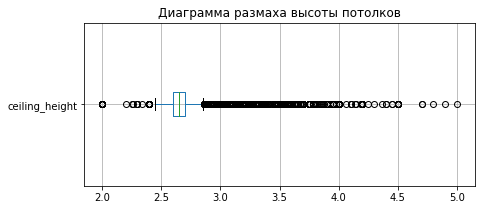

In [94]:
data.boxplot(column='ceiling_height', figsize=(7,3), vert=False);
plt.title('Диаграмма размаха высоты потолков');
data['ceiling_height'].describe()

Значение медианы - 2.65 м. Среднее значение площади не сильно отличается от медианы и составляет 2.69 м. Среднее отклонение после удаления выбросов невысокое - 0.21. Максимальное значени составляет 5 м. Минимальными значениями были оставлены объекты с высотой потолка 2 м.

#### Этаж квартиры (`floor`)

Рассмотрим значения этажей объектов - построим для них гистограмму и вычислим описательные статистические показатели.

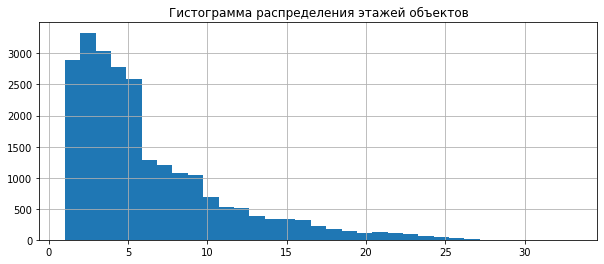

In [95]:
data['floor'].hist(bins=data['floor'].nunique(), figsize=(10,4));
plt.title('Гистограмма распределения этажей объектов');

Как видно из графика, чаще всего продают квартиры, находящиеся на нижних этажах - чаще всего на 2-м этаже. Также, это может быть связано с продажей квартир в старых пятиэтажных домах. Наибольшая часть объектов находится не выше 10-го этажа.

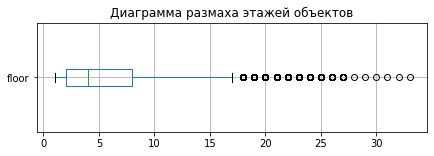

In [96]:
data.boxplot(column='floor', figsize=(7,2), vert=False);
plt.title('Диаграмма размаха этажей объектов');

Максимальные значения этажей составляет 33.

#### Тип этажа квартиры (`floor_type`)

Рассмотрим тип этажей объектов - построим для них гистограмму.

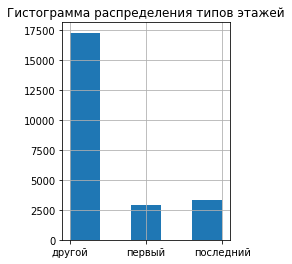

In [97]:
data['floor_type'].hist(bins=5, figsize=(3,4));
plt.title('Гистограмма распределения типов этажей');

Как видно из графика, квартиры на первом и последнем этажах продают реже, чем другие. Квартиры на последнем этаже продают чаще (всего 14.15% от всех объектов), чем на первом (доля 12.25%). Другие этажи составляют 73.61% объектов.

In [98]:
floor_types = pd.DataFrame(data['floor_type'].value_counts())
floor_types['%'] = (floor_types['floor_type'] / len(data) * 100).round(2)
floor_types

,floor_type,%
другой,17264,73.61
последний,3318,14.15
первый,2872,12.25


#### Общее количество этажей в доме (`floors_total`)

Рассмотрим общее количество этажей в домах объектов - построим для них гистограмму.

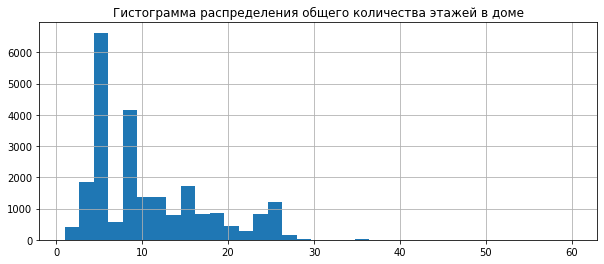

In [99]:
data['floors_total'].hist(bins=data['floors_total'].nunique(), figsize=(10,4));
plt.title('Гистограмма распределения общего количества этажей в доме');

Как мы видим, чаще продают квартиры в пятиэтажных и девятиэтажных домах. Существенное число объектов приходится и на дома, имеющие 20-30 этажей.

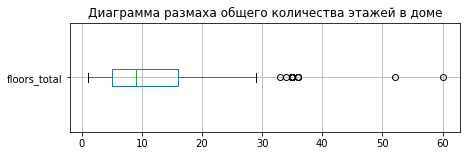

In [100]:
data.boxplot(column='floors_total', figsize=(7,2), vert=False);
plt.title('Диаграмма размаха общего количества этажей в доме');

В данных присутствуют и дома, имеющие более 50 этажей. Взглянем на них.

In [101]:
data.query('floors_total > 50')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_square_meter,exposition_year,exposition_month,exposition_weekday,floor_type,cityCenters_nearest_km,last_price_mln
2253,12,3800000.0,45.5,2018-06-28,2,2.88,60,27.4,4,NaN,False,False,7.4,0,Кронштадт,67763.0,49488.0,2,342.0,3,614.0,166.0,83516.483516,2018,6,3,другой,49.0,3.800
16731,9,3978000.0,40.0,2018-09-24,1,2.65,52,10.5,18,NaN,False,False,14.0,0,Санкт-Петербург,20728.0,12978.0,1,793.0,0,NaN,45.0,99450.000000,2018,9,0,другой,13.0,3.978


Таких объекта лишь два - квартиры в высотках Санкт-Петербурга и Кронштадта.

#### Расстояние до центра города в метрах (`cityCenters_nearest`)

Рассмотрим расстояние от объекта до центра города в метрах - построим для них гистограмму и вычислим описательные статистические показатели.

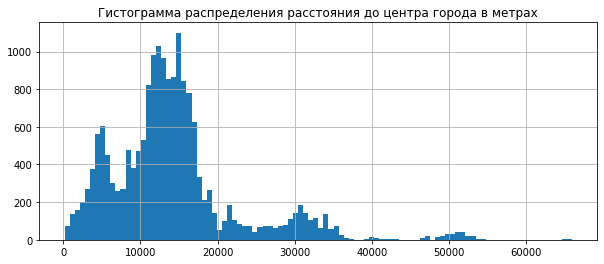

In [102]:
data['cityCenters_nearest'].hist(bins=100, figsize=(10,4));
plt.title('Гистограмма распределения расстояния до центра города в метрах');

Как мы видим, наибольшая часть продаваемых квартир находится на расстоянии 10-20 км от центра города. На расстоянии до 5 км также имеется существенный всплеск значений - квартиры, находящие неподалеку от центра, довольно часто можно найти в продаже.

count    17958.000000
mean     14238.830215
std       8606.490647
min        181.000000
25%       9328.000000
50%      13138.000000
75%      16294.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

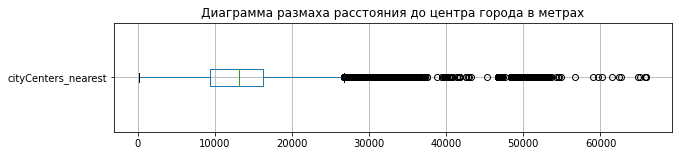

In [103]:
data.boxplot(column='cityCenters_nearest', figsize=(10,2), vert=False);
plt.title('Диаграмма размаха расстояния до центра города в метрах');
data['cityCenters_nearest'].describe()

Значение медианы - 13.1 км. Среднее значение расстояния не сильно отличается от медианы и составляет 14.2 км. Среднее отклонение весьма высокое - 8.6 км. Максимальное значение составляет 66 км. Минимальным значением является расстояние 181 м до центра города.

#### Расстояние до ближайшего аэропорта (`airports_nearest`)

Рассмотрим расстояние от объекта до ближайшего аэропорта - построим для них гистограмму и вычислим описательные статистические показатели.

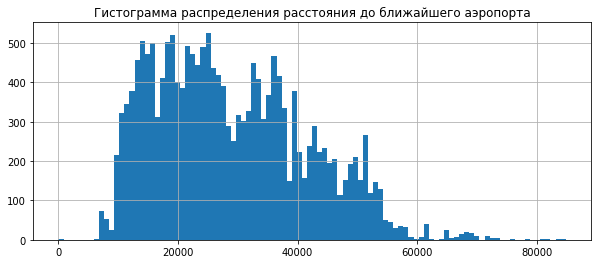

In [104]:
data['airports_nearest'].hist(bins=100, figsize=(10,4));
plt.title('Гистограмма распределения расстояния до ближайшего аэропорта');

Наибольшая часть объектов находится достаточно далеко от аэропортов - расстояние варьируется в диапазоне 10-60 км.

count    17936.000000
mean     28822.596343
std      12656.061969
min          0.000000
25%      18539.000000
50%      26801.000000
75%      37315.250000
max      84869.000000
Name: airports_nearest, dtype: float64

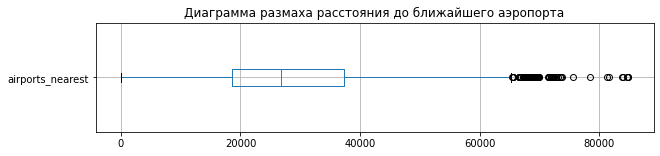

In [105]:
data.boxplot(column='airports_nearest', figsize=(10,2), vert=False);
plt.title('Диаграмма размаха расстояния до ближайшего аэропорта');
data['airports_nearest'].describe()

Значение медианы - 26.8 км. Среднее значение расстояния не сильно отличается от медианы и составляет 28.8 км. Среднее отклонение весьма высокое - 12.6 км. Максимальное значение составляет 85 км. Минимальным значением является нулевое расстояние до аэропорта. Рассмотрим минимальные значения более подробно.

In [106]:
data.sort_values(by='airports_nearest')[['total_area', 'rooms', 'floors_total', 'locality_name', 'airports_nearest', 'cityCenters_nearest']].head(5)

,total_area,rooms,floors_total,locality_name,airports_nearest,cityCenters_nearest
21085,34.7,1,9,Санкт-Петербург,0.0,22801.0
4017,35.0,1,9,Санкт-Петербург,6450.0,17461.0
12899,56.0,2,9,Санкт-Петербург,6450.0,17461.0
7778,29.0,1,4,Санкт-Петербург,6914.0,21486.0
23150,62.5,2,24,Санкт-Петербург,6949.0,13165.0


Мы видим, что объект, расположенный в нулевой близости к аэропорту является однокомнатной квартирой в девятиэтажном здании в Санкт-Петербурге и удален от центра города на 22.8 км. Вполне возможно, что данное значение близости к аэропорту является ошибкой, поскольку ближайшие аэропорты (Пулково, Ржевка, Левашово) от центра Санкт-Петербурга расположены на расстоянии 15-18 км, но не 22.8 км. Заменим данное значение на пропуск `NaN` - это не скажется на ходе исследования, поскольку данный столбец изначально имел 5542 пропуска.

In [107]:
data.loc[data['airports_nearest'] == 0, 'airports_nearest'] = np.nan

#### Расстояние до ближайшего парка (`parks_nearest`)

Рассмотрим расстояние от объекта до ближайшего парка - построим для них гистограмму и вычислим описательные статистические показатели.

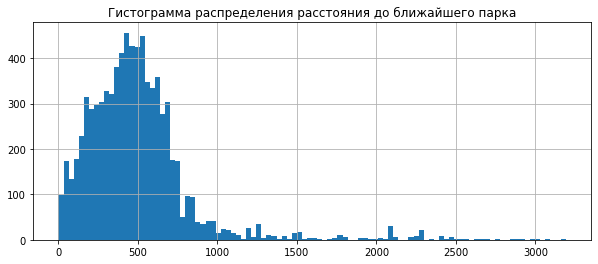

In [108]:
data['parks_nearest'].hist(bins=100, figsize=(10,4));
plt.title('Гистограмма распределения расстояния до ближайшего парка');

Как видно из графика, величина имеет нормальное распределение с большим количеством выбивающихся значений. Большинство квартир находятся в шаговой доступности к паркам, или же расстояние до них не превышает 1 км.

count    7955.000000
mean      491.110119
std       342.317238
min         1.000000
25%       288.000000
50%       455.000000
75%       613.000000
max      3190.000000
Name: parks_nearest, dtype: float64

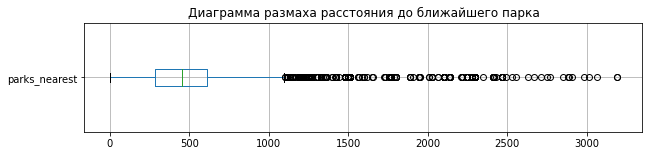

In [109]:
data.boxplot(column='parks_nearest', figsize=(10,2), vert=False);
plt.title('Диаграмма размаха расстояния до ближайшего парка');
data['parks_nearest'].describe()

Значение медианы - 455 м. Среднее значение расстояния не сильно отличается от медианы и составляет 491 м. Максимальное значение составляет 3 190 м. Минимальным значением является 1 м до парка.

#### День и месяц публикации объявления (`exposition_weekday`/`exposition_month`)

Рассмотрим данные о днях и месяцах публикации объявлений - построим для них гистограмму и вычислим описательные статистические показатели.

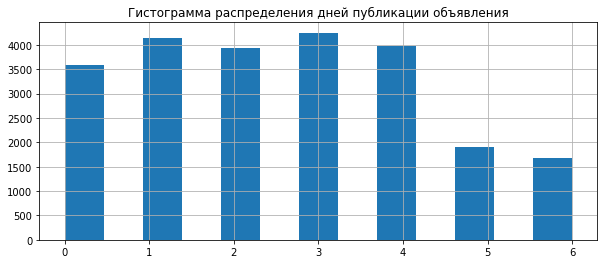

In [110]:
data['exposition_weekday'].hist(bins=13, figsize=(10,4));
plt.title('Гистограмма распределения дней публикации объявления');

Как мы видим, наибольшая активность среди продаж квартир проявлялась по четвергам и вторникам, хотя сравнивать будние дни между собой не имеет особого смысла. Зато заметна разница с выходными днями - в субботу и воскресение активность значительно падала, что обусловлено нерабочими днями среди риэлторов и обычных граждан.

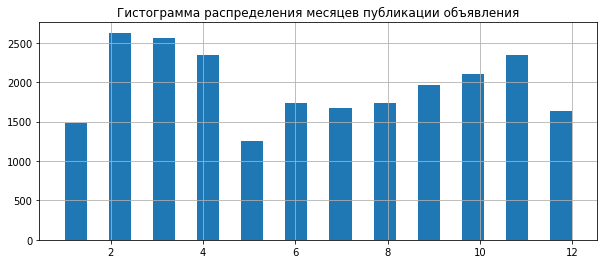

In [111]:
data['exposition_month'].hist(bins=23, figsize=(10,4));
plt.title('Гистограмма распределения месяцев публикации объявления');

Рассматривая время публикации в разрезе месяцев, можно отметить, что пик продаж объектов недвижимости приходится на начало года - февраль, март и апрель. Далее, в мае - наблюдается самый значительный спад. Осенью (сентябрь-ноябрь) происходит также заметное оживление рынка недвижимости сравнительно с весенним временем.

### Анализ времени экспозиции квартир <a class='anchor' id='step_4_2'></a>

Рассмотрим, как быстро продавались квартиры (столбец `days_exposition`). Этот параметр показывает, сколько дней было размещено каждое объявление.

Построим гистограмму и вычислим среднее и медиану.

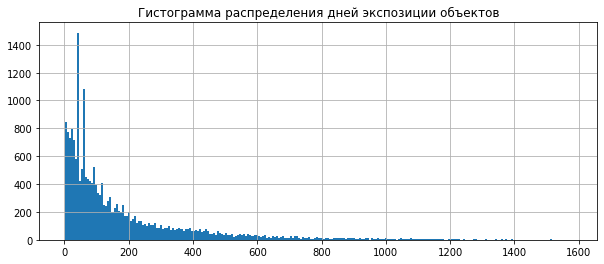

In [112]:
data['days_exposition'].hist(bins=250, figsize=(10,4));
plt.title('Гистограмма распределения дней экспозиции объектов');

Как мы видим, распределение величины напоминает пуассоновское, поскольку связано в временными параметрами. Наибольшая часть объектов продается в течение 1-2 лет (до 600 дней). На графике видны сильные выбросы в районе 45 и 95 дней - эти отметки соответствуют 1-му квартилю и медиане выборки. Также, заметны выбросы в районе 60 дней. Наблюдается длинный "хвост" высоких значений, который свидетельствует о весьма долгих сроках продажи некоторых объектов.

count    20314.000000
mean       180.437925
std        219.453580
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

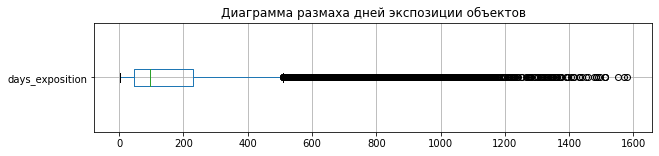

In [113]:
data.boxplot(column='days_exposition', figsize=(10,2), vert=False)
plt.title('Диаграмма размаха дней экспозиции объектов')
data['days_exposition'].describe()

Медианное значение дней, в течение которых продается объект - 95 дней (3 месяца). Среднее значение отличается в 2 раза - 180 дней (6 месяцев). Очень высокое значение принимает среднее отклонение - 219. Это вызвано наличием очень высоких максимальных значений - продажа некоторых объектов занимала 1580 дней (около 5 лет). Узнаем количество таких объектов.

In [114]:
len(data.query('days_exposition > 1000'))

273

Квартир, продажа которых занимала более 3-х лет, не так много - 273 объекта. 

Рассмотрим, третий квартиль выборки (75% данных) - он равняется 231 дню.
Будем считать, что продажа в течение более 231 дня - необычно долгий срок.

На основе графика и расчет межквартильного размаха можно утверждать, что сверхбыстрыми продажами квартир можно считать 45 дней - это является первым квартилем выборки (25% данных).

[Назад к содержанию](#table_of_contents)

## Шаг 5. Анализ факторов, влияющих на общую (полную) стоимость объекта <a class='anchor' id='step_5'></a>

### Общий анализ

Рассмотрим гипотезы, зависит ли цена от:
- общей площади;
- жилой площади;
- площади кухни;
- количества комнат;
- этажа, на котором расположена квартира (первый, последний, другой);
- даты размещения (день недели, месяц, год).

Отберем датафрейм с необходимыми столбцами и рассчитаем для них коэффициенты корреляции по методу Пирсона. На основе полученного датафрейма `selected_data` построим тепловую карту.

Для корректного анализа столбец `floor_type` с помощью лямбда-функции переведем в категориальную переменную и назовем его `floor_type_int`, где:
- значение 0 - "другой" этаж;
- значение 1 - "первый" этаж;
- значение 2 - "последний" этаж.

In [115]:
selected_data = data[['last_price',
                      'total_area', 
                      'living_area', 
                      'kitchen_area', 
                      'rooms',
                      'floor_type']]

selected_data['floor_type_int'] = data['floor_type'].apply(lambda x: 0 if x == 'другой' else (1 if x == 'первый' else 2))

selected_data.corr()

,last_price,total_area,living_area,kitchen_area,rooms,floor_type_int
last_price,1.000000,0.679799,0.565243,0.479701,0.368298,-0.021403
total_area,0.679799,1.000000,0.901092,0.573872,0.747721,0.021331
living_area,0.565243,0.901092,1.000000,0.391959,0.853270,0.055020
kitchen_area,0.479701,0.573872,0.391959,1.000000,0.239495,-0.058582
rooms,0.368298,0.747721,0.853270,0.239495,1.000000,0.066662
floor_type_int,-0.021403,0.021331,0.055020,-0.058582,0.066662,1.000000


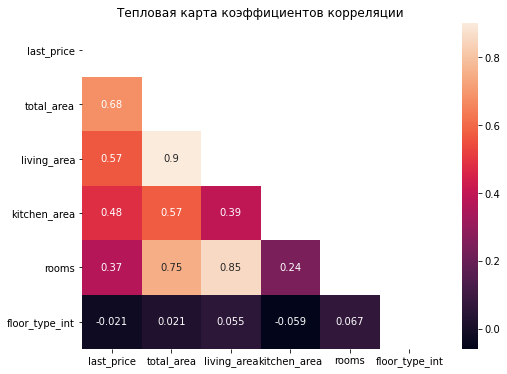

In [116]:
mask = np.triu(np.ones_like(selected_data.corr(), dtype=bool))
f, ax = plt.subplots(figsize=(8, 6))
plt.title('Тепловая карта коэффициентов корреляции')
matrix = np.triu(selected_data.corr())
sns.heatmap(selected_data.corr(), annot=True, mask=matrix);

Как видим, наибольшая корреляция с ценой наблюдается у параметра общей площади. Это вытекает и из здравого смысла: чем больше квартира, тем она дороже. Коэффициент корреляции составляет 0.68, что говорит о достаточно высокой взаимосвязи двух величин.

Остальные параметры, связанные с площадью (жилая площадь, площадь кухни и кол-во комнат), показывают более слабую взаимосвязь - 0.37-0.57. Это является средней, не сильной взаимосвязью.

Любопытно отметить, что количество комнат достаточно слабо влияет на цену - корреляция лишь 0.37. Это подтверждается случаями, когда 1-2-комнатные квартиры в центре города демонстрирует максимальные стоимости на фоне остальной выборки.

Также, мы видим, что тип этажа показывает отсутствие корреляции со стоимостью квартиры - однако, это противоречит здравому смыслу. Опровергнем это утверждение в пункте 4.3.4.

Далее, построим графики для тех параметров, которые показали взаимосвязь с ценой квартиры.

### Взаимосвязь между ценой и площадью (общая, жилая, кухни)

Посмотрим на диаграмму рассеивания для цены и общей площади.

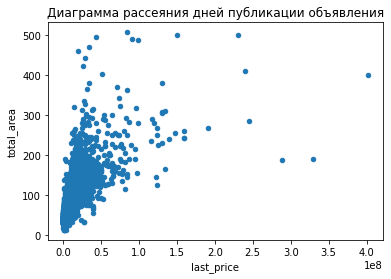

In [117]:
data[['last_price', 'total_area']].plot(kind='scatter',
                                       x='last_price',
                                       y='total_area');
plt.title('Диаграмма рассеяния дней публикации объявления');

Данные величины продемонстрировали наибольшую корреляцию - 0.68. Отчасти это заметно и на диаграмме. Поскольку взаимосвязь умеренно высокая, линию корреляции можно провести под острым углом (относительно оси ординат).

Посмотрим на диаграмму рассеивания для цены и жилой площади.

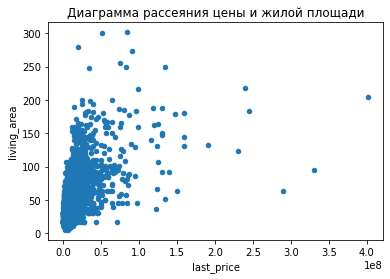

In [118]:
data[['last_price', 'living_area']].plot(kind='scatter',
                                       x='last_price',
                                       y='living_area');
plt.title('Диаграмма рассеяния цены и жилой площади');

Данные величины продемонстрировали среднюю корреляцию - 0.57. Поскольку взаимосвязь средняя, линию корреляции можно провести достаточно размыто.

Посмотрим на диаграмму рассеивания для цены и площади кухни.

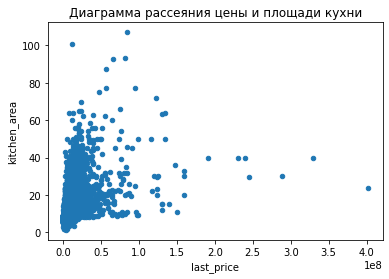

In [119]:
data[['last_price', 'kitchen_area']].plot(kind='scatter',
                                       x='last_price',
                                       y='kitchen_area');
plt.title('Диаграмма рассеяния цены и площади кухни');

Данные величины продемонстрировали среднюю корреляцию - 0.48. Поскольку взаимосвязь средняя, линию корреляции можно провести достаточно размыто.

### Взаимосвязь между ценой и количеством комнат

Посмотрим на диаграмму рассеивания для цены и количества комнат.

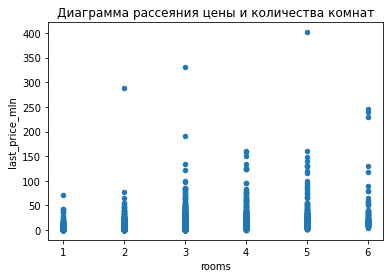

In [120]:
data[['last_price_mln', 'rooms']].plot(kind='scatter',
                                       y='last_price_mln',
                                       x='rooms');
plt.title('Диаграмма рассеяния цены и количества комнат');

Данные величины продемонстрировали слабую корреляцию - 0.37. Поскольку взаимосвязь слабая, линия корреляции недостаточно очевидна на графике.

### Взаимосвязь между ценой и типом этажа

Рассмотрим взаимосвязь между ценой и типом этажа, построив сводную таблицу.

In [121]:
types_grouped = data.pivot_table(index='floor_type', 
                                 values='last_price_mln',
                                 aggfunc=['median', 'mean', 'count'])
types_grouped.columns = ['median', 'mean', 'count']
types_grouped['%'] = (types_grouped['count'] / len(data) * 100).round(2)
types_grouped

,median,mean,count,%
floor_type,,,,
другой,4.8,6.576004,17264,73.61
первый,3.9,4.712475,2872,12.25
последний,4.3,6.582629,3318,14.15


Как мы видим из сводной таблицы, квартиры на первом этаже стоят дешевле - их медианная цена составляет 3.9 млн руб. Однако, их предложение также меньше, чем у других объектов - квартир на первом этаже лишь 12.25%. Квартиры на последнем этаже стоят на 10% дешевле (4.3 млн руб.), чем квартиры на других этажах (4.8 млн руб.) 

### Взаимосвязь между ценой и годом продажи

Рассмотрим взаимосвязь между ценой и годом продажи недвижимости, создав сводную таблицу в разрезе различных лет.

In [122]:
years_grouped =  data.pivot_table(index='exposition_year', 
                                  values='last_price_mln', 
                                  aggfunc=['median', 'mean', 'count'])
years_grouped.columns = ['median', 'mean', 'count']
years_grouped['%'] = (years_grouped['count'] / len(data) * 100).round(2)
years_grouped

,median,mean,count,%
exposition_year,,,,
2014,7.64,12.046600,136,0.58
2015,5.30,8.256386,1157,4.93
2016,4.50,6.774174,2735,11.66
2017,4.50,6.246911,8111,34.58
2018,4.55,5.883250,8459,36.07
2019,5.03,6.565151,2856,12.18


Самые высокие цены на жилье наблюдались в 2014 году (значение медианы 7.64 млн руб.) по сравнению со всеми остальными годами (в 2015-2019 гг. - 4.5-5.3 млн руб.), начиная с 2015 г. снижение составило более 30%. В 2014 году было зафиксировано меньше всего продаж объектов - 0.58%. Больше всего квартир на продажу было выставлено в 2017 и 2018 годах - 8 111 и 8 459 (35% и 36% от всех данных соответственно).

### Цены 1 кв. м в различных населенных пунктах

Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Создадим сводную таблицу `top_localities`, в которой рассчитаем количество объектов, среднее, медиану и процент объявлений в населенном пункте от общего числа.

In [123]:
top_localities = data.pivot_table(index='locality_name', 
                                  values='price_per_square_meter', 
                                  aggfunc=['count', 'mean', 'median'])

top_localities.columns = ['count', 'mean', 'median']

top_localities['%'] = (top_localities['count'] / len(top_localities)).round(3)

top_localities['mean'] = top_localities['mean'].astype('int')
top_localities['median'] = top_localities['median'].astype('int')

top_localities.sort_values(by='count', ascending=False).head(10)

,count,mean,median,%
locality_name,,,,
Санкт-Петербург,15547,114487,104761,48.433
поселок Мурино,551,85601,86042,1.717
поселок Шушары,439,78551,76829,1.368
Всеволожск,398,68654,65789,1.240
Пушкин,368,103100,99993,1.146
Колпино,337,75333,74722,1.050
поселок Парголово,326,90332,91780,1.016
Гатчина,307,68746,67796,0.956
деревня Кудрово,299,92473,91860,0.931


Как мы видим, по числу объектов недвижимости лидирует Санкт-Петербург - их количество 15630 (49% от всех объявлений). Также, в рамках данного топ-10 Санкт-Петербург имеет в среднем самую дорогую стоимость квадратного метра недвижимости - 114 745 руб./кв.м. Медианные значения ниже и составляют 104 761 руб./кв.м.

Самую дешевую стоимость квадратного метра в рамках данного топ-10 имеет Выборг. Цена 1 кв.м здесь составляет в среднем 58 141 руб. (медиана имеет близкое значение - 58 158 руб.) Количество объявлений в Выборге составляет 237, что является лишь 0.74% от общего количества объектов.

Тем не менее, данные показатели актуальны только в разрезе списка топ-10. Проверим на всех данных, какие населенные пункты имеют самую дорогую и дешевую цену на 1 кв.м. Отсортируем датафрейм по средним значениям цены.

In [124]:
top_localities.sort_values(by='mean', ascending=False).head(10)

,count,mean,median,%
locality_name,,,,
Зеленогорск,24,115122,101666,0.075
Санкт-Петербург,15547,114487,104761,48.433
поселок Репино,4,104238,86542,0.012
Пушкин,368,103100,99993,1.146
Сестрорецк,183,101757,99678,0.570
поселок Лисий Нос,3,100660,74525,0.009
Кудрово,171,100134,100000,0.533
деревня Мистолово,11,98549,90888,0.034
поселок Левашово,1,96997,96997,0.003


Как мы видим, Зеленогорск демонстрирует даже более высокие цены, чем Санкт-Петербург - 115 122 руб./кв.м. Однако, количество объявлений в Зеленогорске на порядки ниже - всего 24 (0.075%).

Взглянем на самые дешевые цены в аналогичном разрезе.

In [125]:
top_localities.sort_values(by='mean', ascending=True).head(10)

,count,mean,median,%
locality_name,,,,
деревня Старополье,3,11206,11000,0.009
поселок станции Свирь,2,11481,11481,0.006
деревня Вахнова Кара,1,11688,11688,0.003
деревня Выскатка,2,12335,12335,0.006
поселок Совхозный,2,12629,12629,0.006
деревня Малая Романовка,1,12724,12724,0.003
поселок Тесово-4,1,12931,12931,0.003
деревня Сижно,1,13709,13709,0.003
деревня Ям-Тесово,2,13711,13711,0.006


Самая дешевая стоимость зафиксирована в деревне Старополье - 11 206 руб./кв. м. Объявления в этой деревне очень редкие - лишь 3 объекта недвижимости, выставленных на продажу.

### Анализ близости к центру в Санкт-Петербурге

Исследуем, как стоимость объектов зависит от расстояния до центра города. Выделим квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислим среднюю цену каждого километра.

In [126]:
data_st_peterburg = data.query('locality_name == "Санкт-Петербург"')

data_st_peterburg = data_st_peterburg.pivot_table(index='cityCenters_nearest_km',
                                                  values='price_per_square_meter',
                                                  aggfunc=['mean', 'median', 'count']).reset_index()

data_st_peterburg.columns = ['cityCenters_nearest_km', 'mean', 'median', 'count']
data_st_peterburg['mean'] = data_st_peterburg['mean'].astype('int')
data_st_peterburg['median'] = data_st_peterburg['median'].astype('int')
data_st_peterburg.head(10)

,cityCenters_nearest_km,mean,median,count
0,0.0,248023,164074,26
1,1.0,177834,128485,184
2,2.0,158970,123728,303
3,3.0,121562,109707,337
4,4.0,130325,118055,675
5,5.0,140330,127574,891
6,6.0,149451,131905,602
7,7.0,155967,126624,416
8,8.0,124268,122599,590
9,9.0,113159,105813,591


Как видим из сводной таблицы, по мере приближения к центру города увеличивается медианная цена 1 кв. м. Средняя цена ведет себя не так стабильно, но в целом тренд похожий. Чтобы убедиться в этом нагляднее, построим график средней и медианной цены.

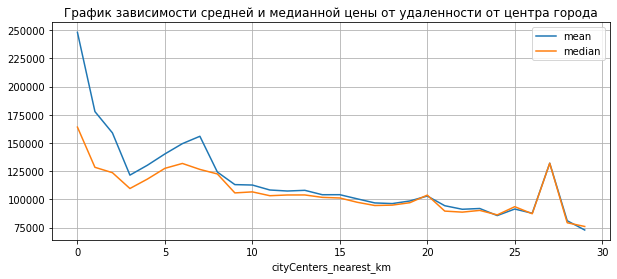

In [127]:
data_st_peterburg.plot(x='cityCenters_nearest_km', 
                       y=['mean', 'median'],
                       grid=True,
                       figsize=(10, 4));
plt.title('График зависимости средней и медианной цены от удаленности от центра города');

Как видно из графика, чем ближе к центру, тем выше цены 1 кв. м. Квартиры в пределах 1-2 км от центра показывают самые высокие цены. Также, дороговизной отличаются и квартиры, расположенные на расстоянии 5-7 км. Вероятно, что такое расстояние является также весьма удобным и оптимальным для жителей. Высокий всплеск цены демонстрируют квартиры, находящиеся на удалении 26-27 км, что, скорее всего, обусловлено желанием покупателей жить поближе к природе и подальше от загрязнения городов (высокий спрос на такие объекты способствует повышению цен).

### Вывод по шагу 5

На данном этапе были решены следующие задачи:

- проведен анализ большинства параметров недвижимости;
- проведен анализ времени экспозиции квартир;
- проведен анализ факторов, влияющих на стоимость квартир;
- рассчитаны цены 1 кв. м в различных населенных пунктах;
- проведен анализ близости к центру города Санкт-Петербург.

[Назад к содержанию](#table_of_contents)

## Выводы <a class='anchor' id='final'></a>

__Шаг 1. Загрузка данных и изучение общей информации.__
1. Изначально в данных присутствовало 23 699 записи. В процессе преобразований количество строк снизилось до 23 454 (на 1%). 
2. Было замечено, что 14 из 22 столбцов содержат пропуски - некоторые из них было решено заполнить медианными значениями, разбив данные на группы по количеству комнат.
3. Некоторые столбцы формата дробных чисел следует перевести к целочисленным значениям. 
4. Столбец с датой `first_day_exposition` следует привести к временному формату.

__Шаг 2. Предобработка данных.__ На данном этапе были решены следующие задачи:
1. Предобработан столбец `rooms`: квартиры с нулевым значением комнат отнесены в категорию однокомнатных; удалены строки с 7 и более комнатами (90 строк удалено). Столбец обрабатывался в первую очередь для заполнения пропусков других столбцов.
2. Предобработан столбец `ceiling_height`: исправлены ошибки в данных (значения более 20 м); удалены строки с высотой потолка более 5 м. Пропуски были заполнены медианными значениями в группировке по количеству комнат.
3. Пропуски столбца `balcony` заполнены нулевыми значениями.
4. Пропуски столбца `living_area` были заполнены внутригрупповыми медианными значениями жилой площади в разбивке по количеству комнат.
5. Пропуски столбца `kitchen_area` были заполнены внутригрупповыми медианными значениями жилой площади в разбивке по количеству комнат.
6. Строки с пропусками столбца `floors_total` были удалены (удалено 86 строк).
7. Строки с пропусками столбца `locality_name` были удалены (удалено 48 строк).
8. Пропуски столбцов `ponds_around3000` и `ponds_around3000`были заполнены нулевыми значениями.
9. Столбец `first_day_exposition` приведен к типу `datetime64`.
10. Столбцы `floors_total`, `balcony`, `parks_around3000` и `ponds_around3000` были приведены к типу `int64`.
11. В столбце `locality_name` обработаны неявные дубликаты - их количество снижено с 364 до 321.

__Шаг 3. Добавление дополнительных параметров.__ На данном этапе были добавлены следующие столбцы:
- `price_per_square_meter` - цена одного квадратного метра;
- `exposition_weekday` - день недели публикации объявления (0 — понедельник, 1 — вторник и т.д.);
- `exposition_month` - месяц публикации объявления;
- `exposition_year` - год публикации объявления;
- `floor_type` - тип этажа квартиры (значения — «первый», «последний», «другой»);
- `cityCenters_nearest_km` - расстояние до центра города в километрах.

__Шаг 4. Исследовательский анализ данных.__
На данном этапе были решены следующие задачи:
- проведен анализ большинства параметров недвижимости;
- проведен анализ времени экспозиции квартир;
- проведен анализ факторов, влияющих на стоимость квартир;
- рассчитаны цены 1 кв. м в различных населенных пунктах;
- проведен анализ близости к центру города Санкт-Петербург.

По итогам исследовательского анализа параметров недвижимости (пункт 4.1.) можно утверждать следующее:

1. Наибольшая часть квартир имеет площадь 50-100 кв. м (около 46% от всех данных).
2. Жилая площадь в среднем не превышает 50 кв. м.
3. Площадь кухни в среднем составляет 5-20 кв. м.
4. Цена большинства объектов недвижимости составляет 5-15 млн руб (около 39% от всех данных). Средняя стоимость составляет 5-6 млн руб.
5. Чаще всего на рынке недвижимости встречаются однокомнатные (35% данных), двухкомнатные (34%) и трехкомнатные квартиры (25%).
6. Большинство объектов имеет высоту потолка 2.5-3 м.
7. Чаще всего продают квартиры, находящиеся на нижних этажах - чаще всего на 2-м этаже. Это может быть связано с продажей квартир в старых пятиэтажных домах. Наибольшая часть объектов находится не выше 10-го этажа.
8. Квартиры на первом и последнем этажах продают реже, чем другие. Квартиры на последнем этаже продают чаще (всего 14.15% от всех объектов), чем на первом (доля 12.25%). Другие этажи составляют 73.61% объектов.
9. Чаще продают квартиры в пятиэтажных и девятиэтажных домах (40% объектов). Существенное число объектов приходится и на дома, имеющие 20-30 этажей (12% объектов).
10. Наибольшая часть продаваемых квартир находится на расстоянии 10-20 км от центра города. На расстоянии до 5 км также имеется существенный всплеск значений - квартиры, находящие неподалеку от центра, довольно часто можно найти в продаже.
11. Наибольшая часть объектов находится достаточно далеко от аэропортов - расстояние варьируется в диапазоне 10-60 км.
12. Большинство квартир находятся в шаговой доступности к паркам, или же расстояние до них не превышает 1 км.
13. Наибольшая активность среди продаж квартир проявлялась по четвергам и вторникам. Заметен спад в выходные дни - в субботу и воскресение активность значительно падает, что обусловлено нерабочими днями среди риэлторов и обычных граждан.

По итогам исследовательского анализа времени экспозиции квартир (пункт 4.2.) можно утверждать следующее:

1. Наибольшая часть объектов продается в течение 1-2 лет (до 600 дней).
2. Медианное значение дней, в течение которых продается объект - 95 дней (3 месяца).
3. Решено считать, что продажа в течение более 231 дня - необычно долгий срок.
4. Сверхбыстрыми продажами квартир решено считать менее 45 дней.

По итогам исследовательского анализа факторов, влияющих на стоимость недвижимости (пункт 4.3.) можно утверждать следующее:
1.  Наибольшая корреляция с ценой наблюдается у параметра общей площади. Это вытекает и из здравого смысла: чем больше квартира, тем она дороже. Коэффициент корреляции составляет 0.68, что говорит о достаточно высокой взаимосвязи двух величин.
2. Остальные параметры, связанные с площадью (жилая площадь, площадь кухни и кол-во комнат), показывают более слабую взаимосвязь - 0.37-0.57. Это является средней, не сильной взаимосвязью.
3. Количество комнат достаточно слабо влияет на цену - корреляция лишь 0.37. Это подтверждается случаями, когда 1-2-комнатные квартиры в центре города демонстрирует максимальные стоимости на фоне остальной выборки.
4. Время публикации объявлений не влияет на стоимость. Временные параметры экспозиции (день, месяц, год) показывают нулевую корреляцию.
5. Квартиры на первом этаже стоят дешевле - их медианная цена составляет 3.9 млн руб. Однако, их предложение также меньше, чем у других объектов - квартир на первом этаже лишь 12.25%. Квартиры на последнем этаже стоят на 10% дешевле (4.3 млн руб.), чем квартиры на других этажах (4.8 млн руб.).
6. Самые высокие цены на жилье наблюдались в 2014 году (значение медианы 7.64 млн руб.) по сравнению со всеми остальными годами (в 2015-2019 гг. - 4.5-5.3 млн руб.), начиная с 2015 г. снижение составило более 30%. 
7. В 2014 году было зафиксировано меньше всего новых объявлений о продаже объектов - 0.58%. Больше всего квартир на продажу было выставлено в 2017 и 2018 годах - 8 111 и 8 459 (35% и 36% от всех данных соответственно).

По итогам исследовательского анализа цены 1 кв. м в различных населенных пунктах (пункт 4.4.) можно утверждать следующее:
1. По числу объектов недвижимости лидирует Санкт-Петербург - их количество 15 630 (49% от всех объявлений). В рамках топ-10 Санкт-Петербург имеет в среднем самую дорогую стоимость квадратного метра недвижимости - 114 745 руб./кв. м. Медианные значения ниже и составляют 104 761 руб./кв. м.
2. Самую дешевую стоимость квадратного метра в рамках топ-10 имеет Выборг. Цена 1 кв. м здесь составляет в среднем 58 141 руб. (медиана имеет близкое значение - 58 158 руб.) Количество объявлений в Выборге составляет 237, что является лишь 0.74% от общего количества объектов.
3. Зеленогорск демонстрирует даже более высокие цены, чем Санкт-Петербург - 115 122 руб./кв. м. Однако, количество объявлений в Зеленогорске на порядки ниже - всего 24 (0.075%).
4. Самая дешевая стоимость зафиксирована в деревне Старополье - 11 206 руб./кв. м. Объявления в этой деревне очень редкие - лишь 3 объекта недвижимости, выставленных на продажу.

По итогам исследовательского анализа близости объекта к центру в Санкт-Петербурге (пункт 4.5.) можно утверждать следующее:

1. Чем ближе к центру города, тем выше медианная цена 1 кв. м. Средняя цена ведет себя не так стабильно, но в целом тренд похожий.
2. Квартиры в пределах 1-2 км от центра показывают самые высокие цены. Также, дороговизной отличаются и квартиры, расположенные на расстоянии 5-7 км. Вероятно, что такое расстояние является также весьма удобным и оптимальным для жителей. 
3. Высокий всплеск цены демонстрируют квартиры, находящиеся на удалении 26-27 км, что, скорее всего, обусловлено желанием покупателей жить поближе к природе и подальше от загрязнения городов (высокий спрос на такие объекты способствует повышению цен).

[Назад к содержанию](#table_of_contents)